#

In [1]:
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns; sns.set()

np.set_printoptions(threshold=np.inf)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import re
from dataclasses import dataclass
from typing import Dict, List

@dataclass
class Stats:
    """Holds a five‐number summary for either latency or req/sec stats."""
    min: float       # Minimum value (ms for latency, numeric for req/sec)
    avg: float       # Average value
    stdev: float     # Standard deviation
    max: float       # Maximum value
    plus_minus: float  # The "+/-" value (a percentage)

@dataclass
class WrkRun:
    version: str
    io_method: str
    test_duration: float         # In seconds
    test_url: str
    threads: int
    connections: int
    latency_stats: Stats         # Latency stats (in ms, except plus_minus as percent)
    req_sec_stats: Stats         # Request per second stats
    latency_distribution: Dict[int, float]  # Maps percentile (0-100) to latency in ms
    total_requests: int
    total_test_time: float       # Test duration in the summary (seconds)
    total_read: str              # e.g. "1.17MB"
    requests_per_sec: float
    transfer_per_sec: str        # e.g. "39.75KB"
    mb_per_sec: float            # Transfer/sec in MB/s
    connect_errors: int          # Number of connect errors
    read_errors: int             # Number of read errors
    write_errors: int            # Number of write errors
    socket_timeouts: int         # Number of socket timeouts

    marker: str
    linestyle: str
    color: str
    name: str
    stats_in_label: bool = True

    @property
    def label(self):
        if not self.stats_in_label:
            return self.name

        return (
            f'{self.name} (Requests/sec: {self.requests_per_sec:.2f}, '
            f'Transfer/sec: {self.transfer_per_sec})'
        )

    @classmethod
    def from_console_output(cls, text: str) -> "WrkRun":
        if text.endswith('.txt'):
            with open(text) as f:
                text = f.read()

        lines = text.splitlines()

        # --- Parse version and I/O method ---
        # Example: "wrk 4.0.0 [epoll] Copyright (C) 2012 Will Glozer"
        m = re.search(r'^wrk\s+([\d.]+)\s+\[(\w+)\]', lines[0])
        if not m:
            raise ValueError("Could not parse version/IO method line")
        version = m.group(1)
        io_method = m.group(2)

        # --- Parse test duration and URL ---
        # Example: "Running 30s test @ http://dgx:4444/generate/..."
        m = re.search(r'Running\s+([\d.]+)s\s+test\s+@\s+(\S+)', lines[1])
        if not m:
            raise ValueError("Could not parse test duration and URL")
        test_duration = float(m.group(1))
        test_url = m.group(2)

        # --- Parse threads and connections ---
        # Example: "  14 threads and 14 connections"
        m = re.search(r'^\s*(\d+)\s+threads\s+and\s+(\d+)\s+connections', lines[2])
        if not m:
            raise ValueError("Could not parse threads and connections")
        threads = int(m.group(1))
        connections = int(m.group(2))

        # --- Parse Thread Stats ---
        # We assume the next lines are:
        #   Latency   130.40ms  197.38ms   54.41ms 528.61ms   89.19%
        #   Req/Sec     1.00      5.63      2.32    10.00     67.76%
        latency_line = lines[4].strip()
        req_sec_line = lines[5].strip()

        def parse_time(s: str) -> float:
            s = s.strip()
            if s.endswith("us"):
                return float(s[:-2]) / 1000.0  # Convert microseconds to milliseconds
            elif s.endswith("ms"):
                return float(s[:-2])           # Already in milliseconds
            elif s.endswith("s"):
                return float(s[:-1]) * 1000.0   # Convert seconds to milliseconds
            else:
                raise ValueError(f"Unknown time unit in string: {s}")

        def parse_percent(s: str) -> float:
            return float(s.rstrip("%"))

        # Parse Latency stats.
        latency_parts = latency_line.split()
        if latency_parts[0] != "Latency":
            raise ValueError("Expected a line starting with 'Latency'")
        latency_stats = Stats(
            min=parse_time(latency_parts[1]),
            avg=parse_time(latency_parts[2]),
            stdev=parse_time(latency_parts[3]),
            max=parse_time(latency_parts[4]),
            plus_minus=parse_percent(latency_parts[5])
        )

        def parse_req_sec_value(s: str) -> float:
            s = s.strip()
            if s.endswith("k"):
                return float(s[:-1]) * 1000.0
            return float(s)

        # Parse Req/Sec stats.
        req_sec_parts = req_sec_line.split()
        if req_sec_parts[0] != "Req/Sec":
            raise ValueError("Expected a line starting with 'Req/Sec'")
        req_sec_stats = Stats(
            min=parse_req_sec_value(req_sec_parts[1]),
            avg=parse_req_sec_value(req_sec_parts[2]),
            stdev=parse_req_sec_value(req_sec_parts[3]),
            max=parse_req_sec_value(req_sec_parts[4]),
            plus_minus=parse_percent(req_sec_parts[5])
        )

        # --- Parse Latency Distribution ---
        # Look for the block starting with "Latency Distribution"
        distribution: Dict[int, float] = {}
        dist_start = None
        for i, line in enumerate(lines):
            if "Latency Distribution" in line:
                dist_start = i + 1
                break
        if dist_start is None:
            raise ValueError("Could not find 'Latency Distribution' block")
        # Updated regex now captures a unit suffix (e.g., us, ms, s)
        distribution_pattern = re.compile(r'^\s*(\d+)%\s+([\d.]+)([a-z]+)')
        for line in lines[dist_start:]:
            m = distribution_pattern.match(line)
            if m:
                percentile = int(m.group(1))
                value = float(m.group(2))
                unit = m.group(3).lower()
                # Normalize the latency value to milliseconds.
                if unit == "us":
                    latency_ms = value / 1000.0
                elif unit == "ms":
                    latency_ms = value
                elif unit == "s":
                    latency_ms = value * 1000.0
                else:
                    raise ValueError(f"Unknown latency unit: {unit}")
                distribution[percentile] = latency_ms
            else:
                break

        # --- Parse Summary Line ---
        # Example: "  2128 requests in 30.06s, 1.17MB read"
        summary_line = None
        for line in lines:
            if "requests in" in line:
                summary_line = line.strip()
                break
        if summary_line is None:
            raise ValueError("Could not find summary line")
        m = re.search(r'^(\d+)\s+requests\s+in\s+([\d.]+)s,\s+(\S+)\s+read', summary_line)
        if not m:
            raise ValueError("Could not parse summary line")
        total_requests = int(m.group(1))
        total_test_time = float(m.group(2))
        total_read = m.group(3)

        # --- Parse Socket Errors (if present) ---
        # Example: "  Socket errors: connect 0, read 0, write 0, timeout 60"
        connect_errors = 0
        read_errors = 0
        write_errors = 0
        socket_timeouts = 0
        for line in lines:
            if line.strip().startswith("Socket errors:"):
                m = re.search(
                    r'Socket errors:\s+connect\s+(\d+),\s+read\s+(\d+),\s+write\s+(\d+),\s+timeout\s+(\d+)',
                    line)
                if m:
                    connect_errors = int(m.group(1))
                    read_errors = int(m.group(2))
                    write_errors = int(m.group(3))
                    socket_timeouts = int(m.group(4))
                break

        # --- Parse Requests/sec ---
        requests_per_sec = None
        for line in lines:
            if line.startswith("Requests/sec:"):
                m = re.search(r'Requests/sec:\s+([\d.]+)', line)
                if m:
                    requests_per_sec = float(m.group(1))
                break
        if requests_per_sec is None:
            raise ValueError("Could not find Requests/sec value")

        # --- Parse Transfer/sec ---
        transfer_per_sec = None
        for line in lines:
            if line.startswith("Transfer/sec:"):
                m = re.search(r'Transfer/sec:\s+(\S+)', line)
                if m:
                    transfer_per_sec = m.group(1)
                break
        if transfer_per_sec is None:
            raise ValueError("Could not find Transfer/sec value")

        # Calculate MB/sec from Transfer/sec.
        mb_per_sec = 0.0
        if transfer_per_sec.endswith("KB"):
            mb_per_sec = float(transfer_per_sec[:-2]) / 1024.0
        elif transfer_per_sec.endswith("MB"):
            mb_per_sec = float(transfer_per_sec[:-2])
        elif transfer_per_sec.endswith("GB"):
            mb_per_sec = float(transfer_per_sec[:-2]) * 1024.0
        else:
            raise ValueError(f"Unknown transfer unit: {transfer_per_sec}")

        return cls(
            version=version,
            io_method=io_method,
            test_duration=test_duration,
            test_url=test_url,
            threads=threads,
            connections=connections,
            latency_stats=latency_stats,
            req_sec_stats=req_sec_stats,
            latency_distribution=distribution,
            total_requests=total_requests,
            total_test_time=total_test_time,
            total_read=total_read,
            requests_per_sec=requests_per_sec,
            transfer_per_sec=transfer_per_sec,
            mb_per_sec=mb_per_sec,
            connect_errors=connect_errors,
            read_errors=read_errors,
            write_errors=write_errors,
            socket_timeouts=socket_timeouts,
            marker='o',
            linestyle='-',
            color='blue',
            name='Run 1',
        )

    def plot_cdf_matplotlib(self):
        import matplotlib.pylab as plt

        percentiles = sorted(self.latency_distribution.keys())
        latencies = [self.latency_distribution[p] for p in percentiles]

        # Convert percentiles to cumulative probabilities (0 to 1)
        cdf_values = [p / 100 for p in percentiles]

        # Plot the CDF: x-axis is latency (ms), y-axis is the cumulative probability
        plt.figure(figsize=(10, 6))
        plt.plot(
            latencies,
            cdf_values,
            marker=self.marker or 'o',
            linestyle=self.linestyle or '-',
            color=self.color or 'blue',
        )
        plt.xlabel('Latency (ms)')
        plt.ylabel('Cumulative Probability')
        plt.title('Latency Distribution CDF')
        plt.grid(True)
        plt.show()

    def set_plot_details(self, marker, linestyle, color, name):
        self.marker = marker
        self.linestyle = linestyle
        self.color = color
        self.name = name

    def plot_cdf_callback_matplotlib(self, plt):
        percentiles = sorted(self.latency_distribution.keys())
        latencies = [self.latency_distribution[p] for p in percentiles]

        # Convert percentiles to cumulative probabilities (0 to 1)
        cdf_values = [p / 100 for p in percentiles]

        # Plot the CDF: x-axis is latency (ms), y-axis is the cumulative probability
        plt.plot(
            latencies,
            cdf_values,
            marker=self.marker or 'o',
            linestyle=self.linestyle or '-',
            color=self.color or 'blue',
        )

    @classmethod
    def plot_cdfs_matplotlib(cls, runs: List['WrkRun']):
        import matplotlib.pylab as plt

        plt.figure(figsize=(10, 6))

        for run in runs:
            run.plot_cdf_callback_matplotlib(plt)

        plt.xlabel('Latency (ms)')
        plt.ylabel('Cumulative Probability')
        plt.title('Latency Distribution CDF')
        plt.grid(True)
        plt.show()

    # ---------------------------------------------------------------------------
    # Seaborn equivalents below
    # ---------------------------------------------------------------------------

    def plot_cdf_seaborn(self):
        """Single-run plot using seaborn (self-contained figure)."""
        import matplotlib.pyplot as plt
        import seaborn as sns
        import pandas as pd

        sns.set_theme(style="whitegrid")

        # Extract data from self.latency_distribution
        percentiles = sorted(self.latency_distribution.keys())
        latencies = [self.latency_distribution[p] for p in percentiles]
        cdf_values = [p / 100 for p in percentiles]

        # Create a DataFrame for Seaborn
        df = pd.DataFrame({
            'Latency (ms)': latencies,
            'Cumulative Probability': cdf_values
        })

        plt.figure(figsize=(8, 6))

        # Plot with a label for the line
        ax = sns.lineplot(
            data=df,
            x='Latency (ms)',
            y='Cumulative Probability',
            marker=self.marker or 'o',
            color=self.color or 'blue',
            label=self.label or 'Latency CDF'
        )

        # Set line style if needed: adjust only the line just added
        if ax.lines:
            ax.lines[-1].set_linestyle(self.linestyle or '-')

        # Set labels and title
        ax.set_xlabel('Latency (ms)')
        ax.set_ylabel('Cumulative Probability')
        ax.set_title('Latency Distribution CDF')
        ax.legend()
        plt.show()

    def plot_cdf_callback_seaborn(self, ax):
        """
        Plot the CDF for a single run on the given matplotlib Axes (using seaborn).
        This is analogous to your matplotlib callback.
        """
        import seaborn as sns
        import pandas as pd

        # Extract data from self.latency_distribution
        percentiles = sorted(self.latency_distribution.keys())
        latencies = [self.latency_distribution[p] for p in percentiles]
        cdf_values = [p / 100 for p in percentiles]

        # Create a DataFrame for seaborn
        df = pd.DataFrame({
            'Latency (ms)': latencies,
            'Cumulative Probability': cdf_values
        })

        # Plot using seaborn's lineplot on the provided Axes
        sns.lineplot(
            data=df,
            x='Latency (ms)',
            y='Cumulative Probability',
            marker=self.marker or 'o',
            color=self.color or 'blue',
            label=self.label or 'Latency CDF',
            ax=ax
        )

        # Adjust the line style for the last line (assumed to be the one just plotted)
        if ax.lines:
            ax.lines[-1].set_linestyle(self.linestyle or '-')

    @classmethod
    def plot_cdfs_seaborn(cls, runs: list['WrkRun']):
        """
        Plot CDFs for multiple runs using seaborn.
        Each run's line is drawn on the same Axes so that all appear in one legend.
        """
        import matplotlib.pyplot as plt
        import seaborn as sns

        sns.set_theme(style="whitegrid")

        # Create a figure and axis to plot all runs
        fig, ax = plt.subplots(figsize=(8, 6))

        # Call the callback for each run to add its line to the same axis
        for run in runs:
            run.plot_cdf_callback_seaborn(ax)

        # Set axis labels and title
        ax.set_xlabel('Latency (ms)')
        ax.set_ylabel('Cumulative Probability')
        ax.set_title('Latency Distribution CDF')
        ax.grid(True)
        ax.legend()

        plt.show()

    def plot_rps_mbs_seaborn(self):
        """
        Plot this run's requests per second and MB per second as vertical bars using seaborn.
        The left y-axis shows the reqs/sec (blue) and the right y-axis shows the MB/sec (green).
        """
        import matplotlib.pyplot as plt
        import seaborn as sns
        sns.set_theme(style="whitegrid")

        # Create a figure with twin y-axes.
        fig, ax1 = plt.subplots(figsize=(8, 6))
        ax2 = ax1.twinx()

        # Since this is a single run, we use a dummy x position (0) and
        # offset the bars slightly so they appear side-by-side.
        x = 0
        width = 0.4

        # Plot the reqs/sec on the left y-axis (ax1)
        ax1.bar(x - width / 2, self.requests_per_sec, width=width,
                color='blue', label='Reqs/sec')
        # Plot the MB/sec on the right y-axis (ax2)
        ax2.bar(x + width / 2, self.mb_per_sec, width=width,
                color='green', label='MB/sec')

        # Set a single tick at x and label it with the run’s name.
        ax1.set_xticks([x])
        ax1.set_xticklabels([self.name])

        ax1.set_ylabel('Requests per Second', color='blue')
        ax2.set_ylabel('MB per Second', color='green')

        # Combine legends from both axes.
        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right')

        plt.title(f'{self.name}: Requests/sec and MB/sec')
        plt.show()

    @classmethod
    def plot_rps_mbs_seaborn_runs(cls, runs: list["WrkRun"], log_yscale: list[bool] = None):
        """
        Plot requests per second and MB per second for multiple runs as vertical bars using seaborn.
        For each run, two bars are plotted side-by-side:
          - The blue bar (on the left y-axis) shows requests per second.
          - The green bar (on the right y-axis) shows MB per second.
        The x-axis groups runs by their name.
        """
        import matplotlib.pyplot as plt
        import seaborn as sns
        import numpy as np
        sns.set_theme(style="whitegrid")

        fig, ax1 = plt.subplots(figsize=(8, 6))
        ax2 = ax1.twinx()

        n = len(runs)
        x = np.arange(n)  # one x position per run
        width = 0.35     # width for each bar

        # Gather data from each run.
        reqs = [run.requests_per_sec for run in runs]
        mbs = [run.mb_per_sec for run in runs]
        names = [run.name for run in runs]

        # Plot reqs/sec on the left axis (ax1) and MB/sec on the right axis (ax2).
        ax1.bar(x - width/2, reqs, width=width, color='blue', label='Reqs/sec')
        ax2.bar(x + width/2, mbs, width=width, color='green', label='MB/sec')

        # Set both y-axes to log scale.
        if log_yscale:
            if log_yscale[0]:
                ax1.set_yscale('log')
            if log_yscale[1]:
                ax2.set_yscale('log')

        ax1.set_xlabel('Run')
        ax1.set_ylabel('Requests per Second', color='blue')
        ax2.set_ylabel('MB per Second', color='green')
        ax1.set_xticks(x)
        ax1.set_xticklabels(names)

        # Combine legends from both axes.
        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right')

        plt.title('Requests/sec and MB/sec for Multiple Runs')
        plt.show()

    @classmethod
    def plot_rps_seaborn_runs(cls, runs: list["WrkRun"], log_yscale: bool = False):
        """
        Plot requests per second for multiple runs as vertical bars using seaborn.
        Each run's RPS is plotted as a single bar with the run's name on the x-axis.
        Optionally, the y-axis is set to a log scale if log_yscale is True.
    
        :param runs: List of WrkRun objects.
        :param log_yscale: If True, sets the y-axis to a logarithmic scale.
        """
        import matplotlib.pyplot as plt
        import seaborn as sns
        import numpy as np
        sns.set_theme(style="whitegrid")
    
        fig, ax = plt.subplots(figsize=(8, 6))
    
        n = len(runs)
        x = np.arange(n)  # one x position per run
    
        # Gather data from each run.
        reqs = [run.requests_per_sec for run in runs]
        names = [run.name for run in runs]
    
        # Plot the RPS as vertical bars.
        ax.bar(x, reqs, width=0.6, color='blue', label='Reqs/sec')
    
        # Set the y-axis to log scale if requested.
        if log_yscale:
            ax.set_yscale('log')
    
        ax.set_xlabel('Run')
        ax.set_ylabel('Requests per Second')
        ax.set_xticks(x)
        ax.set_xticklabels(names)
        ax.legend(loc='upper right')
    
        plt.title('Requests/sec for Multiple Runs')
        plt.show()


In [4]:
wr01_1 = WrkRun.from_console_output('wrk-leopard-01-no-gil.txt')
wr01_2 = WrkRun.from_console_output('wrk-leopard-01-gil.txt')

wr01_1.set_plot_details(marker='o', linestyle='-', color='blue', name='No GIL')
wr01_2.set_plot_details(marker='o', linestyle='-', color='red', name='GIL Enabled')

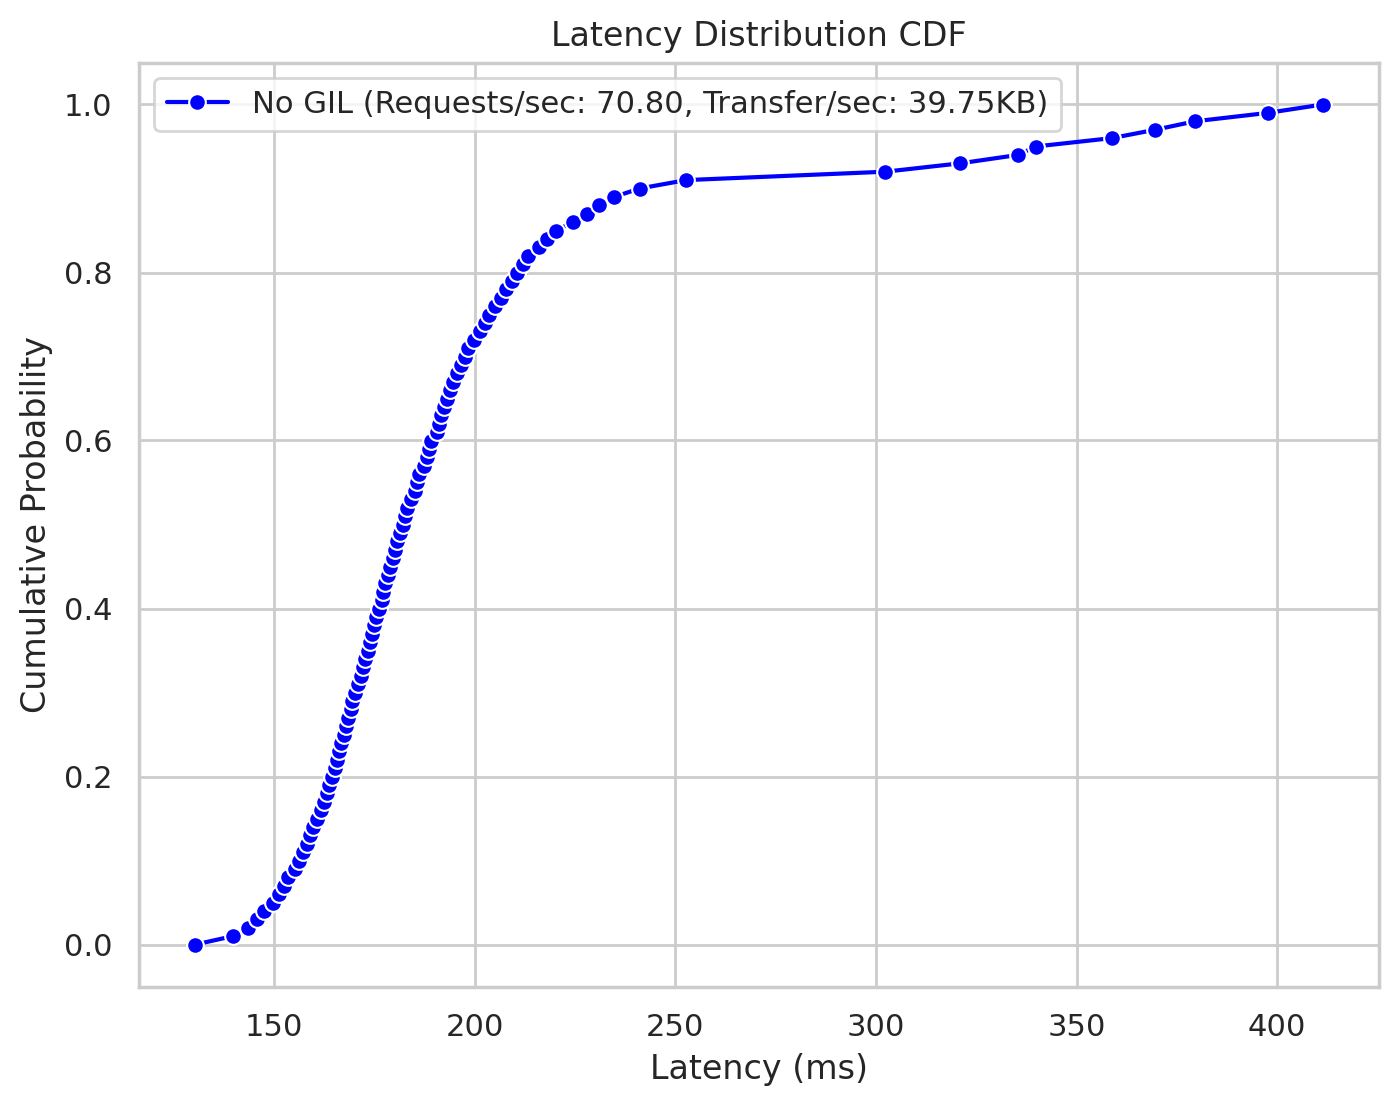

In [5]:
wr01_1.plot_cdf_seaborn()

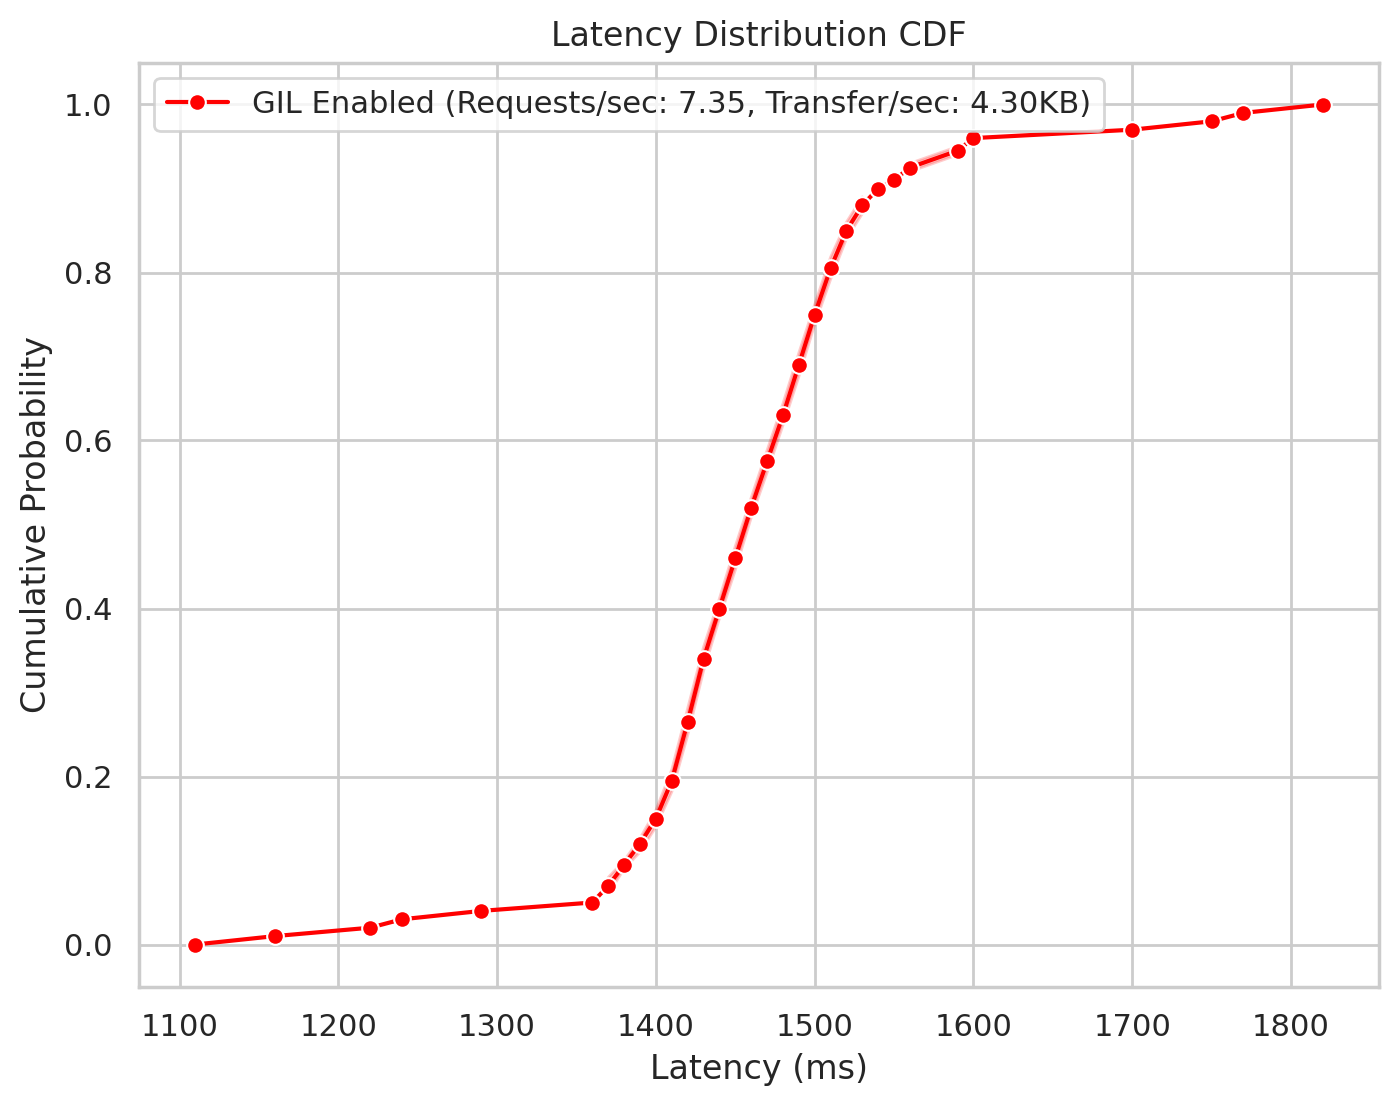

In [6]:
wr01_2.plot_cdf_seaborn()

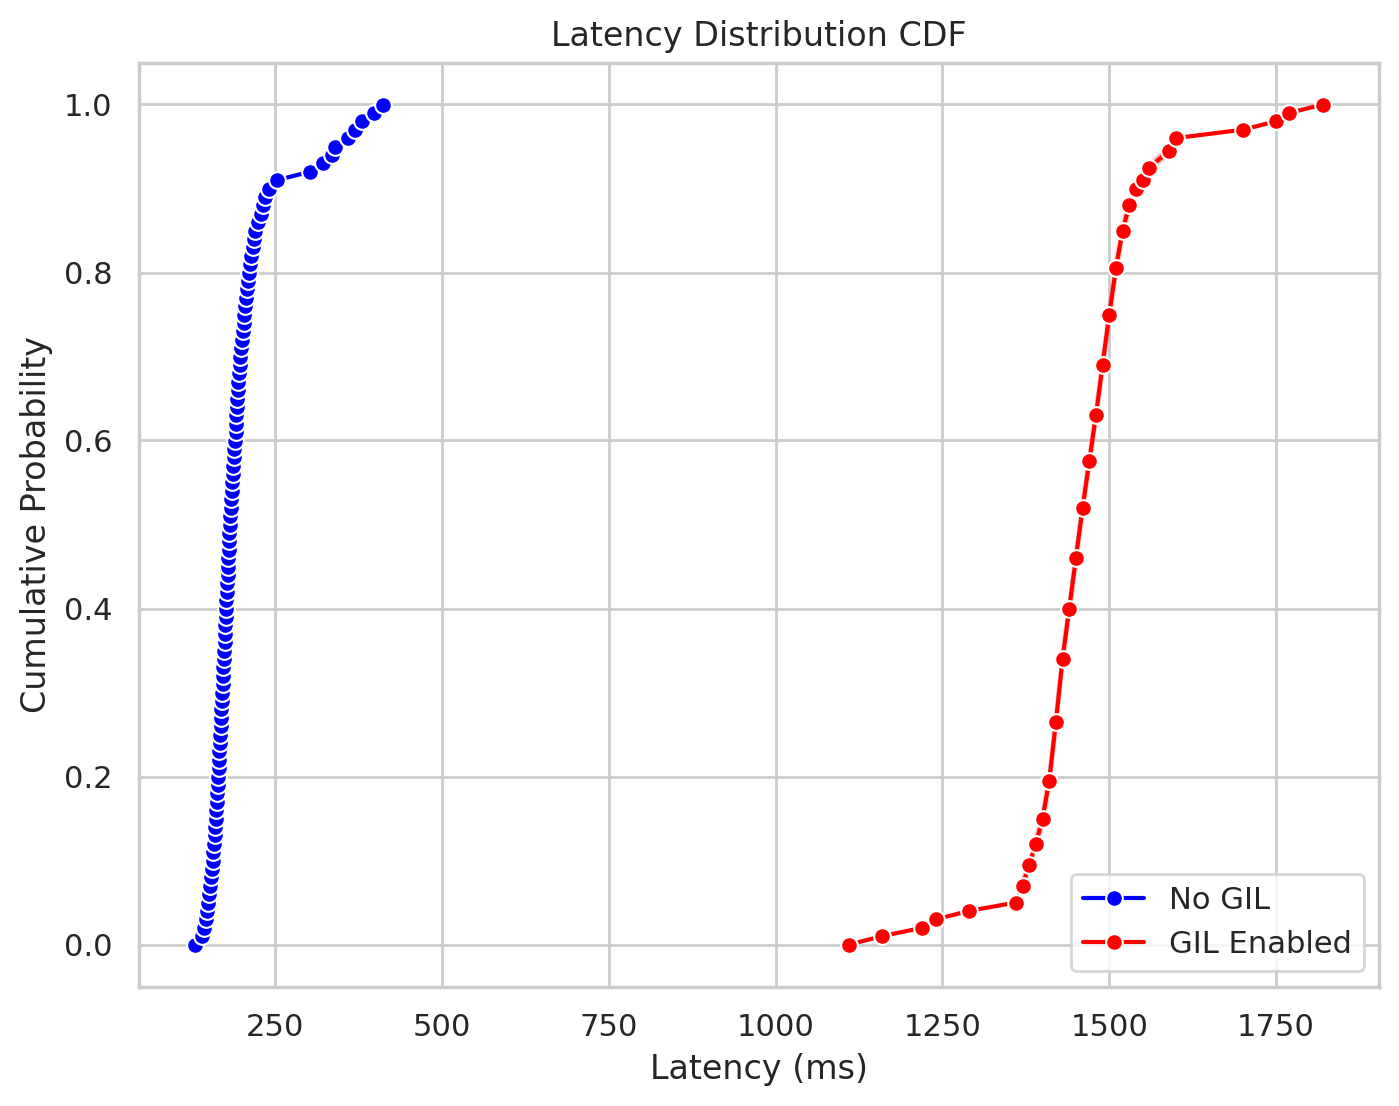

In [7]:
wr01_1.stats_in_label = False
wr01_2.stats_in_label = False
WrkRun.plot_cdfs_seaborn(runs=[wr01_1, wr01_2])

In [8]:
wr02_1 = WrkRun.from_console_output('wrk-leopard-02-no-gil.txt')
wr02_2 = WrkRun.from_console_output('wrk-leopard-01-gil.txt')

wr02_1.set_plot_details(marker='o', linestyle='-', color='blue', name='No GIL')
wr02_2.set_plot_details(marker='o', linestyle='-', color='red', name='GIL Enabled')

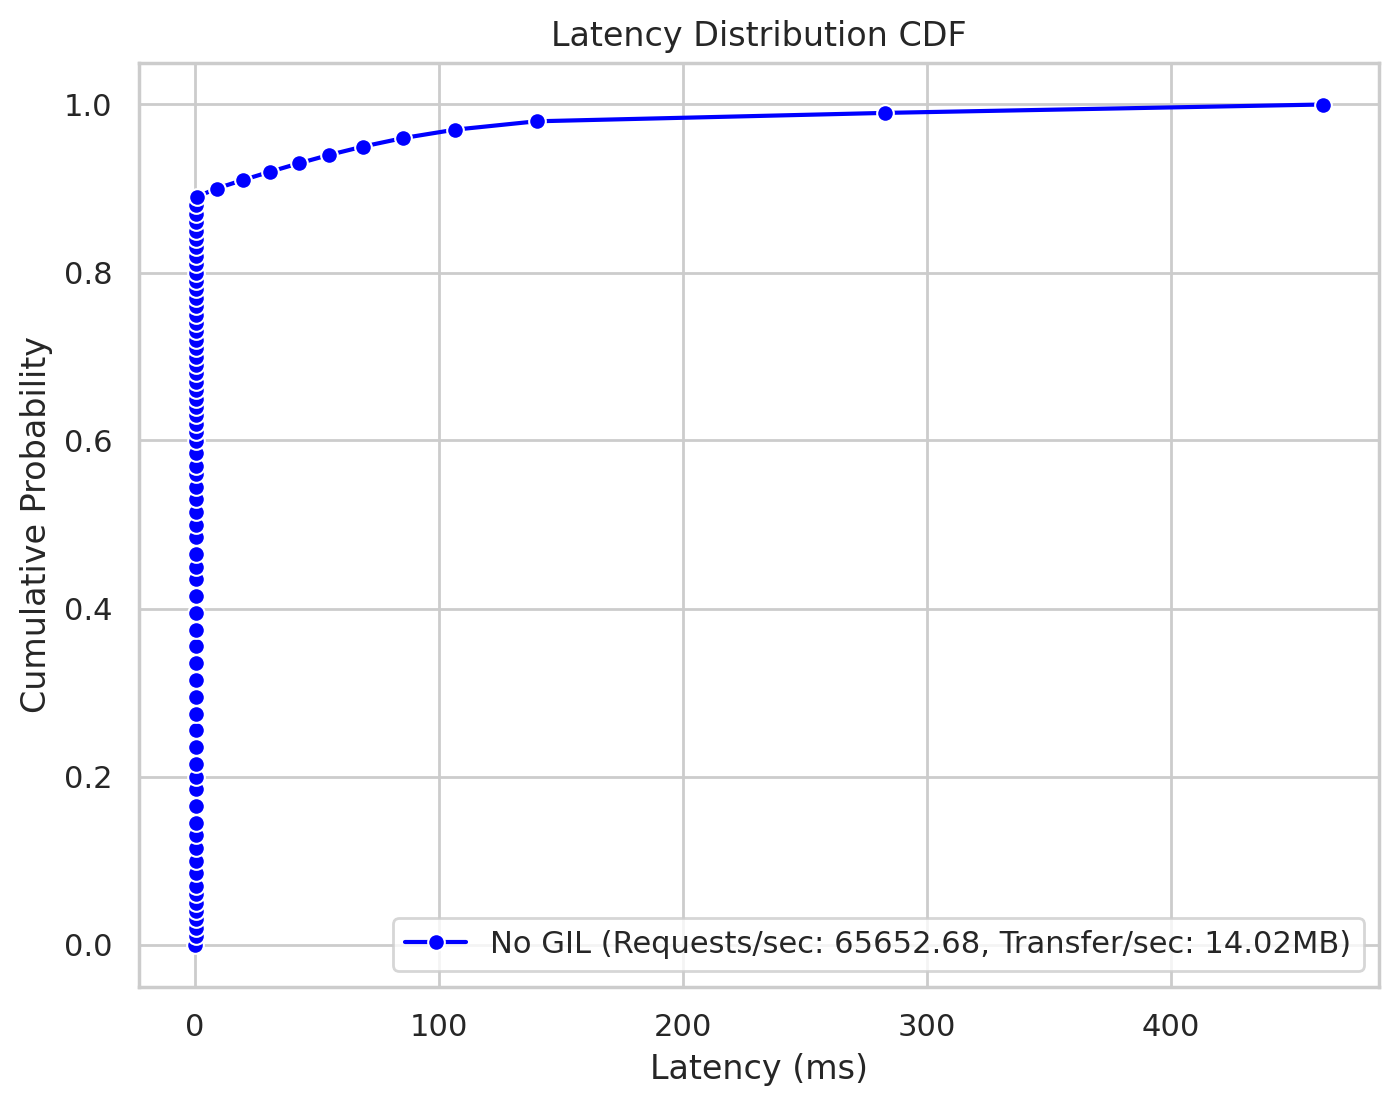

In [9]:
wr02_1.plot_cdf_seaborn()

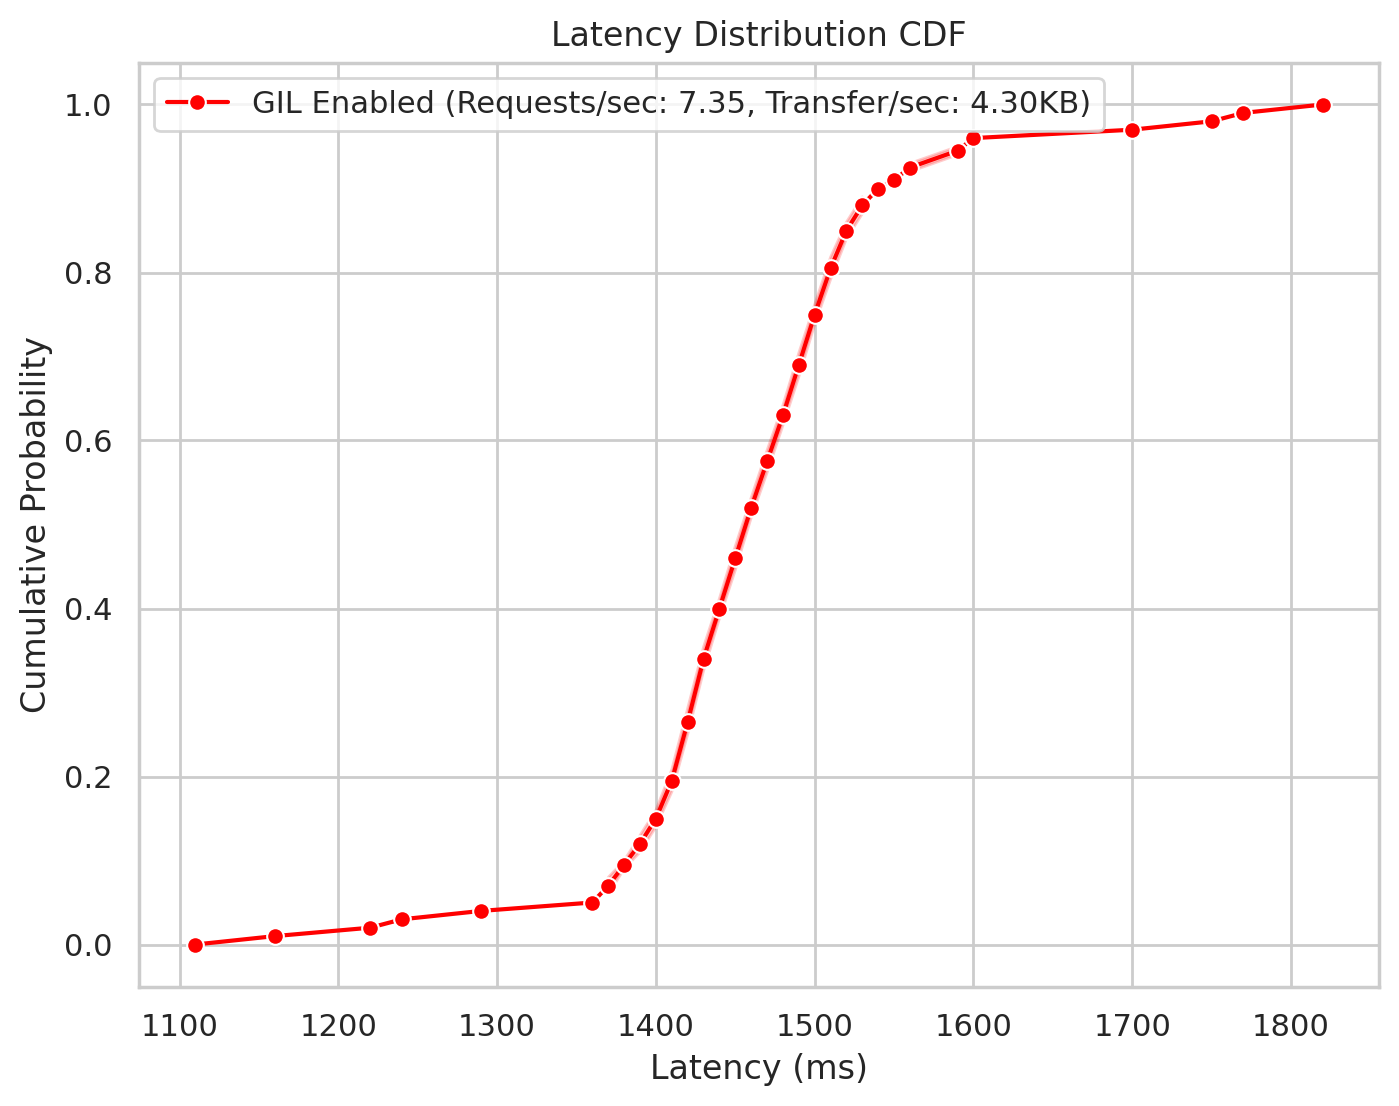

In [10]:
wr02_2.plot_cdf_seaborn()

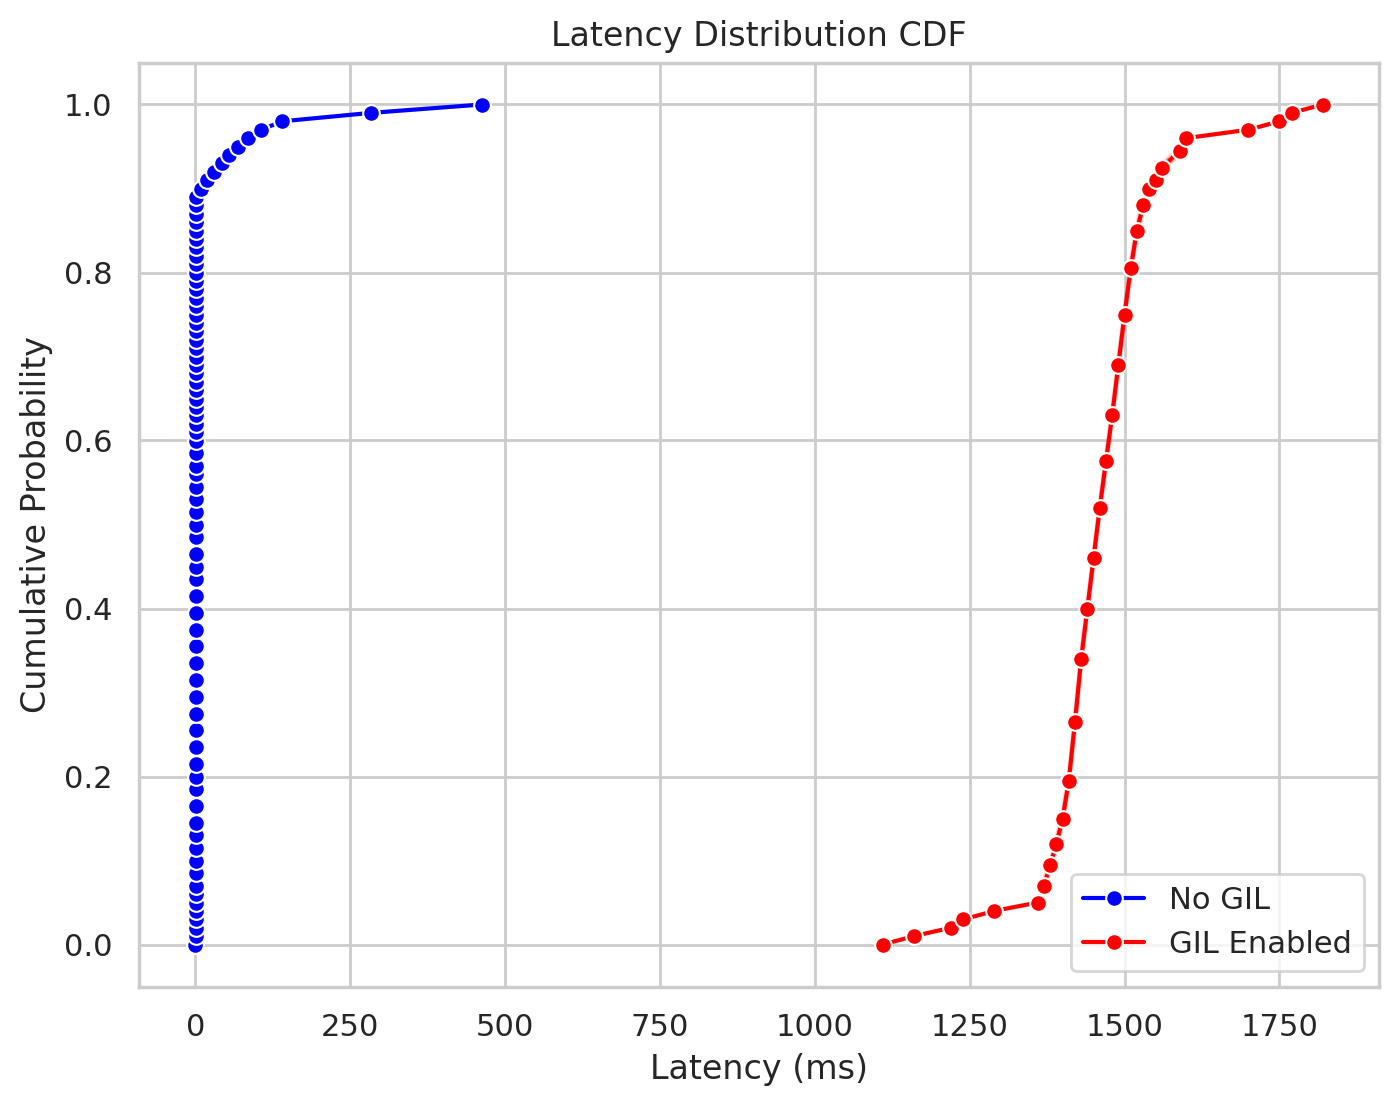

In [11]:
wr02_1.stats_in_label = False
wr02_2.stats_in_label = False
WrkRun.plot_cdfs_seaborn(runs=[wr02_1, wr02_2])

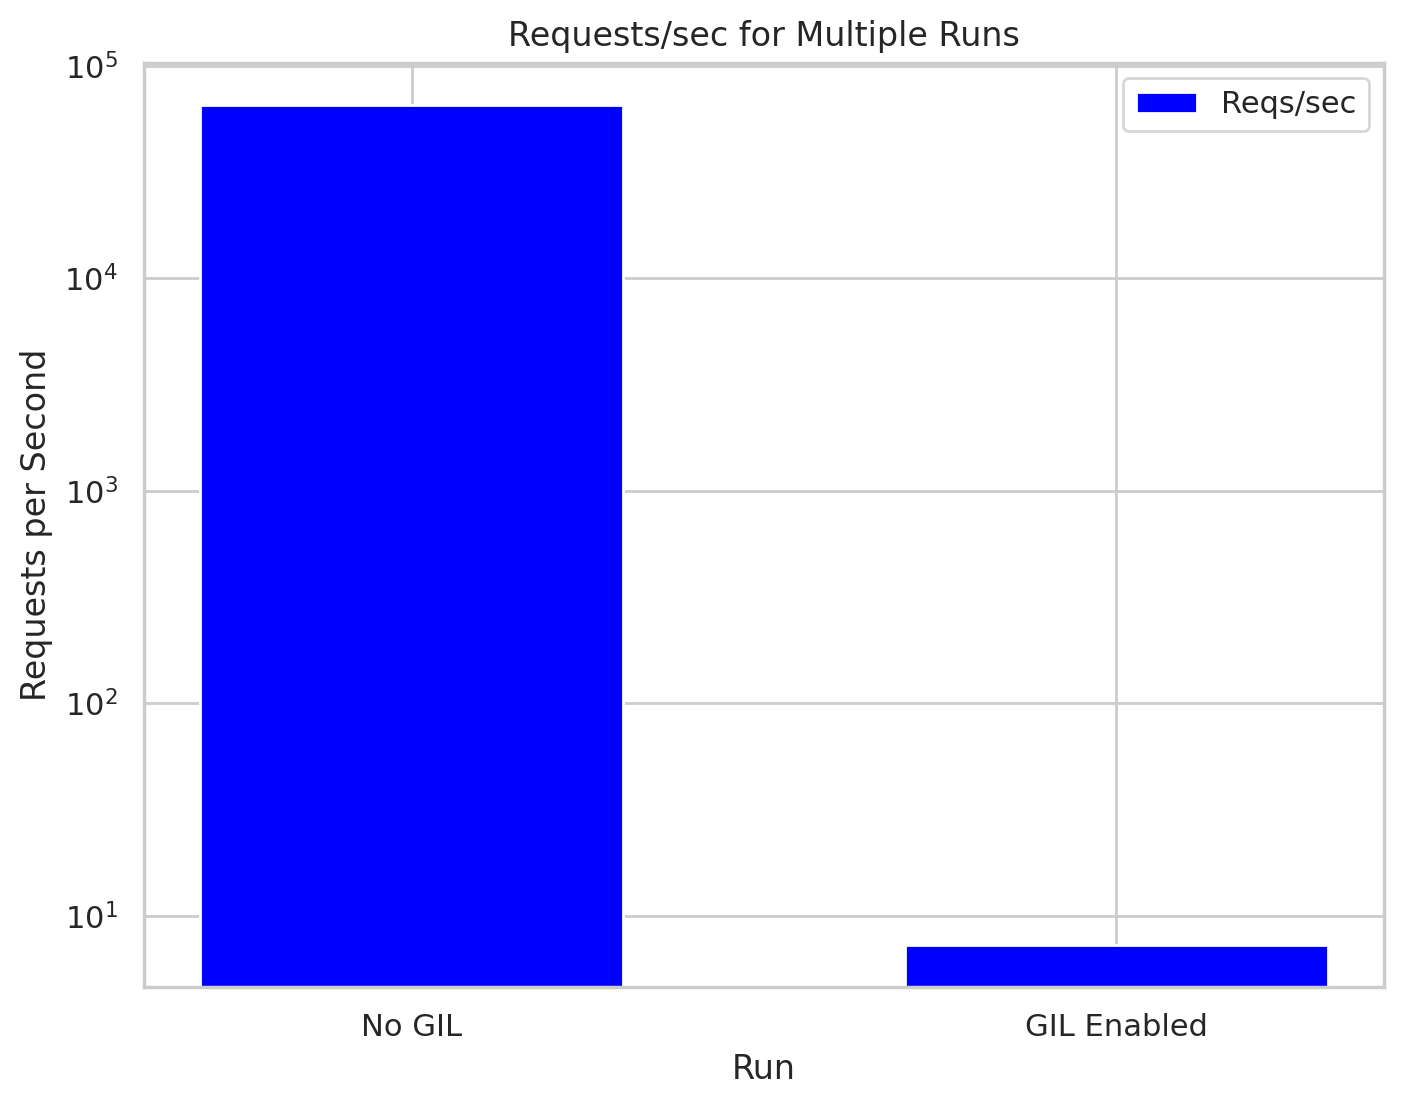

In [12]:
WrkRun.plot_rps_seaborn_runs(runs=[wr02_1, wr02_2], log_yscale=True)

In [13]:
wr02_2.requests_per_sec

7.35